In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.autograd import Variable
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

is_GPU = True

In [2]:
def create_sin_pt():
    # load data and make training set
    data = torch.load('traindata.pt')
    data = data[0][:]
    data = np.expand_dims(data, axis=0)
    print(data.shape)
    input = torch.from_numpy(data[:, :-1])
    #print(input.shape)
    target = torch.from_numpy(data[:, 1:])
    test_input = torch.from_numpy(data[:, :-1])
    print('test_input: ', test_input.shape)
    test_target = torch.from_numpy(data[:, 1:])
    return data, input, target, test_input, test_target

In [3]:
def create_linear():
    step = 5
    start, end = step * np.pi, (step+1)*np.pi   # time range
    # use sin predicts cos
    steps = np.linspace(0, 100, 1000, dtype=np.double)
    #x_np = np.sin(steps)    # float32 for converting torch FloatTensor
    x_np = steps
    data = np.expand_dims(x_np, axis=0)
    input = torch.from_numpy(data[:, :-1])
    #print(input.shape)
    target = torch.from_numpy(data[:, 1:])
    test_input = torch.from_numpy(data[:, :-1])
    test_target = torch.from_numpy(data[:, 1:])
    print('test_input: ', test_input.shape)
    plt.plot(steps, x_np, 'b-', label='input (sin)')
    plt.legend(loc='best')
    plt.show()
    return data, input, target, test_input, test_target

In [4]:
def create_sin():
    step = 5
    start, end = step * np.pi, (step+1)*np.pi   # time range
    # use sin predicts cos
    steps = np.linspace(0, 100, 1000, dtype=np.double)
    x_np = np.sin(steps)    # float32 for converting torch FloatTensor
    #x_np = steps
    data = np.expand_dims(x_np, axis=0)
    input = torch.from_numpy(data[:, :-1])
    #print(input.shape)
    target = torch.from_numpy(data[:, 1:])
    test_input = torch.from_numpy(data[:, :-1])
    test_target = torch.from_numpy(data[:, 1:])
    print('test_input: ', test_input.shape)
    plt.plot(steps, x_np, 'b-', label='input (sin)')
    plt.legend(loc='best')
    plt.show()
    return data, input, target, test_input, test_target

test_input:  torch.Size([1, 999])


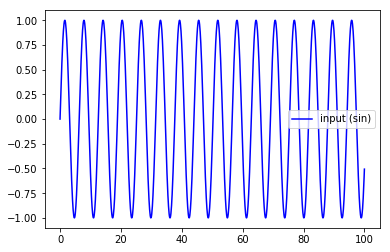

In [5]:
data, input, target, test_input, test_target = create_sin()

Number of position:  80
torch.Size([20])


/home/arg_ws3/.local/lib/python3.5/site-packages/ipykernel_launcher.py:35: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/arg_ws3/.local/lib/python3.5/site-packages/ipykernel_launcher.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


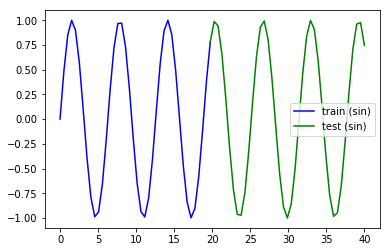

In [6]:
X_LEN = 40
P_NUM = 80
# (x, y, z) ==> (x~y)/z
x_np = np.linspace(0, X_LEN, P_NUM, dtype=np.double)
y_np = np.linspace(0, X_LEN, P_NUM, dtype=np.double)
y_np = np.sin(y_np)    # float32 for converting torch FloatTensor
positions = []
for i in range(P_NUM):
    noise = np.random.rand(1, 1)[0][0]/2.
    positions.append([x_np[i], y_np[i]])
print('Number of position: ', len(positions))


input_x = []
input_y = []
for i in positions[0:20]:
    input_x.append(i[0])
    input_y.append(i[1])
input_x = torch.tensor(input_x)
input_y = torch.tensor(input_y)

target_x = []
target_y = []
for i in positions[20:40]:
    target_x.append(i[0])
    target_y.append(i[1])
target_x = torch.tensor(target_x)
target_y = torch.tensor(target_y)

test_input_x = []
test_input_y = []
for i in positions[40:60]:
    test_input_x.append(i[0])
    test_input_y.append(i[1])
test_input_x = torch.tensor(input_x)
test_input_y = torch.tensor(input_y)
test_target_x = []
test_target_y = []
for i in positions[60:80]:
    test_target_x.append(i[0])
    test_target_y.append(i[1])
test_target_x = torch.tensor(test_target_x)
test_target_y = torch.tensor(test_target_y)

#input = torch.tensor(positions[0:20]).double()
#target = torch.tensor(positions[20:40]).double()
#test_input = torch.tensor(positions[40:60]).double()
#test_target = torch.tensor(positions[60:80]).double()

p_x = []
p_y = []
for i in positions:
    p_x.append(i[0])
    p_y.append(i[1])
print(input_x.shape)
plt.plot(p_x[:40], p_y[:40], 'b-', label='train (sin)')
plt.plot(p_x[39:], p_y[39:], 'g-', label='test (sin)')

plt.legend(loc='best')
plt.show()

In [7]:
class LSTM_RNN(nn.Module):
    def __init__(self):
        super(LSTM_RNN, self).__init__()
        self.hidden_size = 51
        self.batch_size = 1
        self.num_layer = 1
        self.in_size = 20
        self.out_size = 20
        IN_DIM = 1
        
        # Input shape:  torch.Size([1, 1, 2])
        # Input shape:  torch.Size([6, 1, 2])
        self.hidden_x = self.init_hidden()
        self.hidden_y = self.init_hidden()
        self.lstm = nn.LSTM(IN_DIM, self.hidden_size) # IN_DIM, OUT_DIM
        self.linear1 = nn.Linear(20, 100)
        self.linear2 = nn.Linear(20, 100)
        self.linear3 = nn.Linear(200, 50)
        self.linear_x = nn.Linear(51, 1)
        self.linear_y = nn.Linear(51, 1)

    def forward(self, input_x, input_y):        
        '''out, self.hidden = self.lstm(input, self.hidden)
        d_len = int(len(input)/2)
        for i in range(d_len):
            data = input[i:i+d_len]'''
        if is_GPU:
            input_x = input_x.cuda()
            input_y = input_y.cuda()
        out_x = []
        out_y = []
        for i in range(len(input_x)):
            x = input_x[i].view(1, 1, -1)
            y = input_y[i].view(1, 1, -1)
            state_x, self.hidden_x = self.lstm(x, self.hidden_x)
            state_y, self.hidden_y = self.lstm(y, self.hidden_y)
            predict_x = self.linear_x(state_x)
            predict_y = self.linear_y(state_y)
            out_x += [predict_x]
            out_y += [predict_y]
            
        #print(state_x.shape, state_y.shape) #[1,1,51]
        #state_x = state_x.view(1, -1)
        #state_y = state_y.view(1, -1)
        #print(state_x.shape, state_y.shape) #[51]
        #lstm_cat = torch.cat((state_x, state_y), dim=0)
        #print(lstm_cat.shape) #[102]
        for i in range(len(input_x)-1):
            state_x, self.hidden_x = self.lstm(predict_x, self.hidden_x)
            state_y, self.hidden_y = self.lstm(predict_y, self.hidden_y)
            predict_x = self.linear_x(state_x)
            predict_y = self.linear_y(state_y)
            out_x += [predict_x]
            out_y += [predict_y]
            
        out_x = torch.stack(out_x, 1).squeeze(2)
        out_y = torch.stack(out_y, 1).squeeze(2)
        return out_x, out_y
    
    def init_hidden(self):
        if is_GPU:
            hidden = [torch.randn(self.num_layer, self.batch_size, self.hidden_size).cuda(), \
                      torch.randn(self.num_layer, self.batch_size, self.hidden_size).cuda()]
        else:
            hidden = [torch.randn(self.num_layer, self.batch_size, self.hidden_size), \
                      torch.randn(self.num_layer, self.batch_size, self.hidden_size)]
        return hidden
    
    def detach_hidden(self):
        self.hidden_x[0] = self.hidden_x[0].detach()
        self.hidden_x[1] = self.hidden_x[1].detach()
        self.hidden_y[0] = self.hidden_y[0].detach()
        self.hidden_y[1] = self.hidden_y[1].detach()

In [8]:
class LSTM_RNN(nn.Module):
    def __init__(self):
        super(LSTM_RNN, self).__init__()
        self.hidden_size = 51
        self.batch_size = 1
        self.num_layer = 1
        self.in_size = 20
        self.out_size = 20
        IN_DIM = 1
        
        # Input shape:  torch.Size([1, 1, 2])
        # Input shape:  torch.Size([6, 1, 2])
        self.h1_x = self.init_hidden(1,1,51)
        self.c1_x = self.init_hidden(1,1,51)
        self.h1_y = self.init_hidden(1,1,51)
        self.c1_y = self.init_hidden(1,1,51)
        self.h2_x = self.init_hidden(1,1,20)
        self.c2_x = self.init_hidden(1,1,20)
        self.h2_y = self.init_hidden(1,1,20)
        self.c2_y = self.init_hidden(1,1,20)
        self.lstm1 = nn.LSTM(1,  51) # IN_DIM, OUT_DIM
        self.lstm2 = nn.LSTM(51, 20) # IN_DIM, OUT_DIM
        self.linear_x = nn.Linear(20, 1)
        self.linear_y = nn.Linear(20, 1)

    def forward(self, input_x, input_y):        
        '''out, self.hidden = self.lstm(input, self.hidden)
        d_len = int(len(input)/2)
        for i in range(d_len):
            data = input[i:i+d_len]'''
        if is_GPU:
            input_x = input_x.cuda()
            input_y = input_y.cuda()
        out_x = []
        out_y = []
        for i in range(len(input_x)):
            x = input_x[i].view(1, 1, -1)
            y = input_y[i].view(1, 1, -1)
            state_x1, (self.h1_x, self.c1_x) = self.lstm1(x, (self.h1_x, self.c1_x))
            state_y1, (self.h1_y, self.c1_y) = self.lstm1(y, (self.h1_y, self.c1_y))
            state_x2, (self.h2_x, self.c2_x) = self.lstm2(state_x1, (self.h2_x, self.c2_x))
            state_y2, (self.h2_y, self.c2_y) = self.lstm2(state_y1, (self.h2_y, self.c2_y))
            predict_x = self.linear_x(state_x2)
            predict_y = self.linear_y(state_y2)
            out_x += [predict_x]
            out_y += [predict_y]
            
        for i in range(len(input_x)-1):
            state_x1, (self.h1_x, self.c1_x) = self.lstm1(predict_x, (self.h1_x, self.c1_x))
            state_y1, (self.h1_y, self.c1_y) = self.lstm1(predict_y, (self.h1_y, self.c1_y))
            state_x2, (self.h2_x, self.c2_x) = self.lstm2(state_x1, (self.h2_x, self.c2_x))
            state_y2, (self.h2_y, self.c2_y) = self.lstm2(state_y1, (self.h2_y, self.c2_y))
            predict_x = self.linear_x(state_x2)
            predict_y = self.linear_y(state_y2)
            out_x += [predict_x]
            out_y += [predict_y]
            
        out_x = torch.stack(out_x, 1).squeeze(2)
        out_y = torch.stack(out_y, 1).squeeze(2)
        return out_x, out_y
    
    def init_hidden(self, num_layer = 1, batch_size = 1, hidden_size = 51):
        if is_GPU:
            hidden = torch.randn(num_layer, batch_size, hidden_size).cuda()
        else:
            hidden = torch.randn(num_layer, batch_size, hidden_size)
        return hidden
    
    def detach_hidden(self):
        self.h1_x = self.h1_x.detach()
        self.c1_x = self.c1_x.detach()
        self.h1_y = self.h1_y.detach()
        self.c1_y = self.c1_y.detach()
        self.h2_x = self.h2_x.detach()
        self.c2_x = self.c2_x.detach()
        self.h2_y = self.h2_y.detach()
        self.c2_y = self.c2_y.detach()

In [9]:
# build the model
seq = LSTM_RNN()
#seq.load_state_dict(torch.load('seq.pth'))
seq.float()
criterion = nn.MSELoss()
# use LBFGS as optimizer since we can load the whole data to train
#optimizer = optim.LBFGS(seq.parameters(), lr=0.8)
optimizer = torch.optim.Adam(seq.parameters(), lr=0.001)
if is_GPU:
    seq = seq.cuda()
    criterion = criterion.cuda()
#begin to train
# set random seed to 0
np.random.seed(0)
torch.manual_seed(0)

test loss: 0.22677303850650787


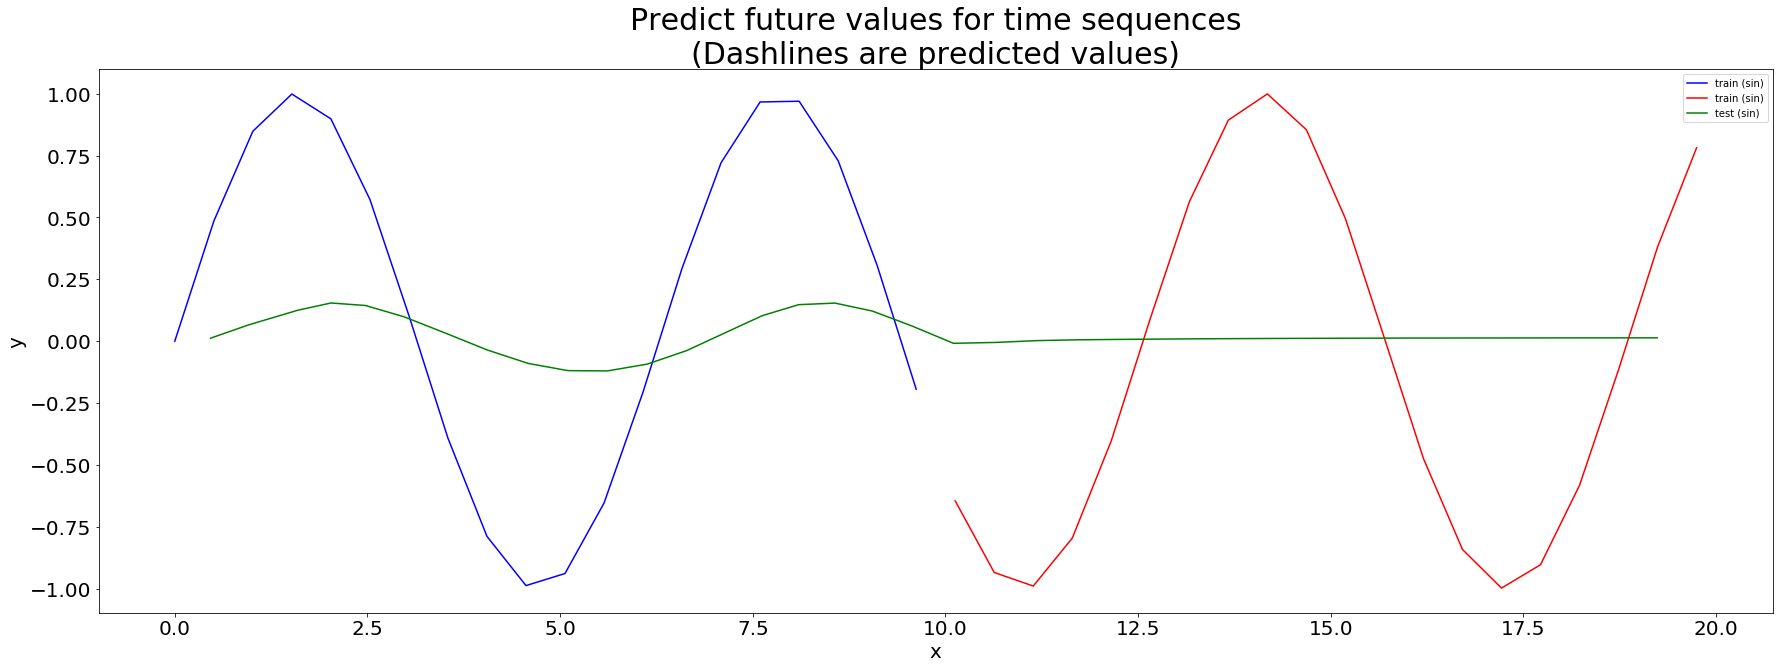

In [24]:
def show_model_lstm():
    with torch.no_grad():
        if is_GPU:
            predict_x, predict_y = seq(input_x.cuda(), input_y.cuda())
        else:
            predict_x, predict_y = seq(input_x, input_y)
        predict_x = predict_x.view(-1)
        predict_y = predict_y.view(-1)
        predict_pos_cat = torch.cat((predict_x, predict_y))
        x_cat = torch.cat((input_x[1:], target_x))
        y_cat = torch.cat((input_y[1:], target_y))
        all_cat = torch.cat((x_cat, y_cat))
        if is_GPU:
            all_cat = all_cat.cuda()
        loss = criterion(predict_pos_cat, all_cat)
        print('test loss:', loss.item())
    plt.figure(figsize=(30,10))
    plt.title('Predict future values for time sequences\n(Dashlines are predicted values)', fontsize=30)
    plt.xlabel('x', fontsize=20)
    plt.ylabel('y', fontsize=20)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    if is_GPU:
        plt.plot(input_x.cpu().numpy(), input_y.cpu().numpy(), 'b-', label='train (sin)')
        plt.plot(target_x.cpu().numpy(), target_y.cpu().numpy(), 'r-', label='train (sin)')
        plt.plot(predict_x.cpu().numpy(), predict_y.cpu().numpy(), 'g-', label='test (sin)')
    else:  
        plt.plot(input_x.numpy(), input_y.numpy(), 'b-', label='train (sin)')
        plt.plot(target_x.numpy(), target_y.numpy(), 'r-', label='train (sin)')
        plt.plot(predict_x.numpy(), predict_y.numpy(), 'g-', label='test (sin)')
    plt.legend(loc='best')
    plt.show()
show_model_lstm()

In [11]:
def show_model():
    with torch.no_grad():
        predict_pos = seq(input_x, input_y)
        input_cat = torch.cat((input_x, input_y))
        predict_pos_cat = torch.cat((predict_pos[0], predict_pos[1]))
        target_cat = torch.cat((target_x, target_y))
        loss = criterion(predict_pos_cat, target_cat)
        print('test loss:', loss.item())
        print()
        print(predict_pos[0])
    plt.figure(figsize=(30,10))
    plt.title('Predict future values for time sequences\n(Dashlines are predicted values)', fontsize=30)
    plt.xlabel('x', fontsize=20)
    plt.ylabel('y', fontsize=20)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.plot(input_x.numpy(), input_y.numpy(), 'b-', label='train (sin)')
    plt.plot(predict_pos[0].numpy(), predict_pos[1].numpy(), 'g-', label='test (sin)')
    plt.legend(loc='best')
    plt.show()

In [12]:
def show_model_RNN():
    with torch.no_grad():
        #if True:
        future = 30
        pred, h_state = seq(test_input, future=future, state = old_state)
        loss = criterion(pred[:, :-future], test_target)
        print('test loss:', loss.item())
        y = pred.cpu().detach().numpy()
        test_input_draw = test_input.cpu().numpy()
    # draw the result
    plt.figure(figsize=(30,10))
    plt.title('Predict future values for time sequences\n(Dashlines are predicted values)', fontsize=30)
    plt.xlabel('x', fontsize=20)
    plt.ylabel('y', fontsize=20)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    def draw(yi, color):
        plt.plot(np.arange(input.size(1)), yi[:input.size(1)], color, linewidth = 2.0)
        plt.plot(np.arange(input.size(1), input.size(1) + future), yi[input.size(1):], color + ':', linewidth = 2.0)
    def new_draw(yi, color, shape):
        if shape == 1:
            plt.plot(np.arange(len(yi)), yi[:len(yi)], color, linewidth = 2.0)
        elif shape == 2:
            plt.plot(np.arange(len(yi)), yi[:len(yi)], color + ':', linewidth = 2.0)
    #print(len(y[0]), test_input_draw[0].shape)
    new_draw(y[0], 'r', 1)
    new_draw(test_input_draw[0], 'g', 2)
    #plt.close()

In [21]:
for param_group in optimizer.param_groups:
    param_group['lr'] = 0.01
    lr = param_group['lr']

In [22]:
def train_lstm():
    EPOCH = 200
    for i in range(EPOCH):
        print('Epoch: ', i)
        if i%50 == 0:
            seq.h1_x = seq.init_hidden(1,1,51)
            seq.c1_x = seq.init_hidden(1,1,51)
            seq.h1_y = seq.init_hidden(1,1,51)
            seq.c1_y = seq.init_hidden(1,1,51)
            seq.h2_x = seq.init_hidden(1,1,20)
            seq.c2_x = seq.init_hidden(1,1,20)
            seq.h2_y = seq.init_hidden(1,1,20)
            seq.c2_y = seq.init_hidden(1,1,20)
            #seq.hidden_x = seq.detach_hidden()
            #seq.hidden_y = seq.detach_hidden()
            #seq.detach_hidden()
        '''if i%250 == 0:
            for param_group in optimizer.param_groups:
                param_group['lr'] *= 0.8
                lr = param_group['lr']'''
        if is_GPU:
            predict_x, predict_y = seq(input_x.cuda(), input_y.cuda())
        else:
            predict_x, predict_y = seq(input_x, input_y)
        predict_x = predict_x.view(-1)
        predict_y = predict_y.view(-1)
        predict_pos_cat = torch.cat((predict_x, predict_y))
        x_cat = torch.cat((input_x[1:], target_x))
        y_cat = torch.cat((input_y[1:], target_y))
        all_cat = torch.cat((x_cat, y_cat))
        if is_GPU:
            all_cat = all_cat.cuda()
        loss = criterion(predict_pos_cat, all_cat)
        print('test loss:', loss.item())
        optimizer.zero_grad()
        loss.backward(retain_graph=True)
        optimizer.step()
train_lstm()

Epoch:  0
test loss: 0.32409143447875977
Epoch:  1
test loss: 0.2534717321395874
Epoch:  2
test loss: 0.2511924207210541
Epoch:  3
test loss: 0.2529013156890869
Epoch:  4
test loss: 0.25133273005485535
Epoch:  5
test loss: 0.2524511516094208
Epoch:  6
test loss: 0.25115054845809937
Epoch:  7
test loss: 0.2517741620540619
Epoch:  8
test loss: 0.2509121596813202
Epoch:  9
test loss: 0.2510997951030731
Epoch:  10
test loss: 0.25048309564590454
Epoch:  11
test loss: 0.2504909634590149
Epoch:  12
test loss: 0.25013241171836853
Epoch:  13
test loss: 0.24997271597385406
Epoch:  14
test loss: 0.2497810274362564
Epoch:  15
test loss: 0.24960407614707947
Epoch:  16
test loss: 0.24951526522636414
Epoch:  17
test loss: 0.24929305911064148
Epoch:  18
test loss: 0.24925941228866577
Epoch:  19
test loss: 0.24903824925422668
Epoch:  20
test loss: 0.24899104237556458
Epoch:  21
test loss: 0.24873557686805725
Epoch:  22
test loss: 0.2486768364906311
Epoch:  23
test loss: 0.2484302520751953
Epoch:  24
te

Epoch:  195
test loss: 0.22789181768894196
Epoch:  196
test loss: 0.22758297622203827
Epoch:  197
test loss: 0.22751553356647491
Epoch:  198
test loss: 0.22718948125839233
Epoch:  199
test loss: 0.22713154554367065


In [42]:
torch.save(seq.state_dict(), './lstm.pth')

In [15]:
def train_linear():
    EPOCH = 5
    for i in range(50):
        print('Epoch: ', i)
        predict_pos = seq(input_x, input_y)
        input_cat = torch.cat((input_x, input_y))
        target_cat = torch.cat((target_x, target_y))
        predict_pos_cat = torch.cat((predict_pos[0], predict_pos[1]))
        loss = criterion(predict_pos_cat, target_cat)
        print('test loss:', loss.item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

Epoch:  0
test loss: 0.06625466048717499
Epoch:  1
test loss: 0.11664199829101562
Epoch:  2
test loss: 0.15235409140586853
Epoch:  3
test loss: 0.144194096326828
Epoch:  4
test loss: 0.1051800325512886
Epoch:  5
test loss: 0.07086729258298874
Epoch:  6
test loss: 0.06349273771047592
Epoch:  7
test loss: 0.0738849863409996
Epoch:  8
test loss: 0.07632672041654587
Epoch:  9
test loss: 0.05812455713748932
Epoch:  10
test loss: 0.03153950721025467
Epoch:  11
test loss: 0.01770968735218048
Epoch:  12
test loss: 0.02335740439593792
Epoch:  13
test loss: 0.03628439083695412
Epoch:  14
test loss: 0.040847305208444595
Epoch:  15
test loss: 0.03361813351511955
Epoch:  16
test loss: 0.02376207709312439
Epoch:  17
test loss: 0.020780550315976143
Epoch:  18
test loss: 0.02439717948436737
Epoch:  19
test loss: 0.026643535122275352
Epoch:  20
test loss: 0.022103868424892426
Epoch:  21
test loss: 0.013817981816828251
Epoch:  22
test loss: 0.008577859960496426
Epoch:  23
test loss: 0.008822320029139519